# CNN for the Classification of Chest X-ray Scans
---

![alt text](imgs/sample_data.png "data")

In this notebook, we define ***and train*** a CNN to classify chest x-ray scans taken from the [dataset](https://github.com/ieee8023/covid-chestxray-dataset) by Joseph Paul Cohen and Paul Morrison and Lan Dao.

Two solutions are provided using [ResNet34](https://arxiv.org/pdf/1512.03385.pdf). The first one, implementing the model directly from torchvision.models and the second one, implementing each layer of the model using torch API. We use [Cross Entropy Loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) and [Stochastic Gradient Descent](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) to train the models. 

Data is separated between a validation and a training set. So that we can measure the model's performance on data it hasn't seen during training and avoid [overfitting](https://medium.com/predict/what-overfitting-is-and-how-to-fix-it-887da4bf2cba).

At the end, this allows us to get an accuracy close to 98% on the validation set.

Please notice parameters such as the *learning_rate*, the *batch_size*.



In [1]:
## Import torch basic libraries
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torch.optim import lr_scheduler

## Import torchvision modules for data loading, augmentation,
## transformation and pretrained models
from torchvision import datasets, transforms, models

## Import additional python libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import copy

## Library used to log data to tensorboard dashb
from tensorboardX import SummaryWriter

In [2]:
# Define which device is available: cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Define writer used to log data to tensorboard
writer = SummaryWriter("runs")
print("device: {}".format(device))


device: cuda:0


### Load the data
In this cell, we load both training and test datasets from the *./data* folder

In [3]:
'''
Define image transformations:
    1. Resize data to 255 x 255
    2. Crop center
    3. Apply a random rotation with a maximum value of 25 degrees
    4. Apply random horizontal flip
    5. Normalize images

Transformations 3 and 4 are only applied to the training set for data augmentation
'''
data_transforms = {
    'train': transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(25),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
    'test': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
}

''' Directory containing data '''
data_dir = 'data'

''' Define image datasets from the folders contained in the data folder
    applying the previously defined transformations'''
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

''' Define dataloaders, used to obtain batches of data in an efficient way '''
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print("Classes are: {}".format(class_names))

Classes are: ['covid', 'noCovid']


### Visualize Data

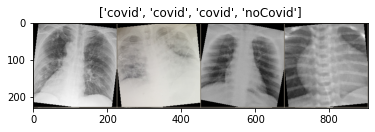

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp[0:229, 0:905, :]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    #plt.show()
    if title is not None:
        plt.title(title[0:4])
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Show some samples of data
imshow(out, title=[class_names[x] for x in classes])

### Define functions for model training and the visualization of model results

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function used to train the model
    Args:
        model: torch model (Deep Convolutional Neural Network) to be trained
        criterion: Loss function to be used in training
        optimizer: Type of optimizer (e.g. SGD, Adam, RMSProp)
        scheduler: Scheduler used to use dynamic learning rate
        num_epochs
    Returns:
        model with trained weights
    '''
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Train for the given number of epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            # Log data to console and summary writter for tensorboard
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            writer.add_scalar('{}/loss'.format(phase), epoch_loss, epoch)
            writer.add_scalar('{}/acc'.format(phase), epoch_acc, epoch)
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Save model to checkpoint file
    torch.save(model.state_dict(), 'checkpoint-best.pth')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model


def visualize_model(model, num_images=6):
    '''
    Function used to visualize the model's results
    Args:
        model: trained model
        num_images: num of images to be evaluated
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # No gradient calculated during evaluation
    with torch.no_grad():
        # Get Data from dataloader
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Infer class from image thtough forward pass on the model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Plot images and predictions
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, real: {}'.format(class_names[preds[j]], class_names[labels.cpu().data[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
# Download resnet 34 model from torchvision.models with pretrained weights
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

#Modify fully connected section of the model for our case (2 classes)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Pass model to the device, depending on gpu or cpu availability
model_ft = model_ft.to(device)

# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Define Optimizer to be used to trained the weightes. Observe that all parameters 
# are being optimized. Alternatively, convolutional layers could be frozen and only 
# train fully connected layers
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train model

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7652 Acc: 0.5065
test Loss: 0.3909 Acc: 0.7711

Epoch 1/9
----------
train Loss: 0.5225 Acc: 0.7143
test Loss: 0.2145 Acc: 0.8795

Epoch 2/9
----------
train Loss: 0.3682 Acc: 0.7987
test Loss: 0.1542 Acc: 0.9398

Epoch 3/9
----------
train Loss: 0.3475 Acc: 0.8247
test Loss: 0.1227 Acc: 0.9518

Epoch 4/9
----------
train Loss: 0.2971 Acc: 0.8571
test Loss: 0.1162 Acc: 0.9518

Epoch 5/9
----------
train Loss: 0.1157 Acc: 0.9610
test Loss: 0.0931 Acc: 0.9880

Epoch 6/9
----------
train Loss: 0.1487 Acc: 0.9286
test Loss: 0.0930 Acc: 0.9759

Epoch 7/9
----------
train Loss: 0.0823 Acc: 0.9870
test Loss: 0.0870 Acc: 0.9759

Epoch 8/9
----------
train Loss: 0.1393 Acc: 0.9416
test Loss: 0.0846 Acc: 0.9759

Epoch 9/9
----------
train Loss: 0.0742 Acc: 0.9805
test Loss: 0.0867 Acc: 0.9759

Training complete in 0m 38s
Best val Acc: 0.987952


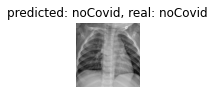

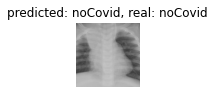

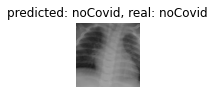

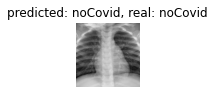

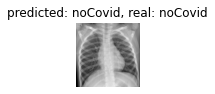

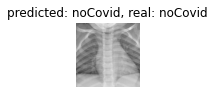

In [8]:
visualize_model(model_ft)

In [1]:
!pip install torchsummary

In [2]:
from resnet import *

In [3]:
model = resnet18(3, 1000)
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
        Conv2dAuto-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
        Conv2dAuto-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
 ResNetBasicBlock-10           [-1, 64, 56, 56]               0
       Conv2dAuto-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
       Conv2dAuto-14           [-1, 64,

In [4]:
import torchvision.models as models
summary(models.resnet18(False).cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,